# Goal: Fine tune a LLM model on an instruction dataset

This notebook needs to be completed. There are placeholders for each of the following tasks which need to be coded up. Finally, this notebook should be runnable on a free Google colab instance in few minutes.

## Concrete tasks:
1. Load the instruction fine-tuning dataset
2. Load the model and tokenizer
3. Prompt the model with few items from the dataset and print the generated responses using the provided `generate()` function
4. Implement a trainer class that takes the model, dataset as inputs and
  - Instantiates necessary training components such as optimizer, learning rate scheduler etc.
  - Specifically, implement the `train()` function that performs the classic train loop with a next-token prediction objective
5. Modify the `generate()` function to implement the generation logic directly using `model.forward()`. At each generation step, generated tokens are fed as inputs until the stopping condition is met (EOS is generated or max_tokens is reached). Most importantly, make sure that the generations are batched.
6. **Plot the effect of training data on the validation loss**: The idea is to vary the amount of data used for training data (e.g. 100, 200, 500, 1000 data points) and understand its effect on the valiation loss. Please provide an explanation along with the plot.
7. **Applying Chat template**: Suppose you want to switch to a different model and accordingly the prompt template needs to change. So, how would you incorporate this change without having to manually apply the template everytime you change the model.

Bonus points:
- You are free to use any model. But if you use a larger model (e.g. Llama model 7-B) and make it trainable on Google Colab with T4 instance in couple of minutes, it is a bonus point.
Hint: you should use techniques such **LoRA/QLoRa** to reduce the number of trainable parameters, use **quantization** to reduce the memory requirements.
- Optimize the `generate()` further to use attention key-value caching. The idea is that we do not want to recompute attention values for our prompt at every decoding step.

# Install Dependencies
If you add any new depencies, make sure to update the following cell accordingly.

In [1]:
!pip install -q accelerate peft transformers bitsandbytes datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━

# Imports
All imports should be added below.

In [2]:
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TrainingArguments, logging
import torch
from huggingface_hub import notebook_login
from transformers import (
    TrainingArguments,
    logging,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer

## 1. Load the instruction fine-tuning dataset


In [3]:
dataset = load_dataset('yizhongw/self_instruct',split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for yizhongw/self_instruct contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/yizhongw/self_instruct
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `dataset

## 2. Load model and tokenizer

In [4]:
################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [5]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load the entire model on the GPU 0
device_map = {"": 0}

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# The model that you want to train from the Hugging Face hub
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
#tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## 3. Prompt the model with few items from the dataset

In [6]:
prompts = [item for item in dataset["prompt"][:2]]
print(prompts)

['Make a list of 10 ways to help students improve their study skills.\n\nOutput:', 'Task: Find out what are the key topics in the document? output "topic 1", "topic 2", ... , "topic n".\n\nThe United States has withdrawn from the Paris Climate Agreement.\n\n']


In [7]:
def generate(prompts):
  pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200, return_full_text=False)
  result = pipe(prompts)
  generated_texts = [item[0]["generated_text"] for item in result]
  return generated_texts

In [8]:
gen_texts = generate(prompts)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [9]:
for prompt, text in zip(prompts, gen_texts):
  print("#############")
  print(f"PROMPT: {prompt}")
  print(f"RESPONSE: {text}")

#############
PROMPT: Make a list of 10 ways to help students improve their study skills.

Output:
RESPONSE: 

1. Create a study schedule: Encourage students to create a study schedule that includes regular study sessions, breaks, and time for review.
2. Eliminate distractions: Encourage students to eliminate distractions while studying, such as turning off their phone or finding a quiet study space.
3. Use active learning techniques: Encourage students to use active learning techniques, such as taking notes, summarizing information, or creating flashcards.
4. Use mnemonic devices: Encourage students to use mnemonic devices to help them remember information, such as acronyms or rhymes.
5. Practice regularly: Encourage students to practice regularly, rather than cramming the night before a test.
6. Take breaks: Encourage students to take breaks during long study sessions to rest
#############
PROMPT: Task: Find out what are the key topics in the document? output "topic 1", "topic 2", ..

In [10]:
split_dataset = dataset.train_test_split(test_size=0.1)

In [11]:
train_ds = split_dataset["train"]
test_ds = split_dataset["test"]

In [77]:
def transform_conversation(example):
    prompt = example['prompt']
    response = example['completion']
    reformatted_segments = []
    reformatted_segments.append(f'<s>[INST] {prompt} [/INST] {response} </s>')
    return {'text': ''.join(reformatted_segments)}

train_dataset = train_ds.shuffle(seed=10).select(range(1000))
train_dataset = train_dataset.map(transform_conversation)

eval_dataset = test_ds.shuffle(seed=10).select(range(100))
eval_dataset = eval_dataset.map(transform_conversation)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [13]:
train_dataset

Dataset({
    features: ['prompt', 'completion', 'text'],
    num_rows: 1000
})

In [12]:
# val_ds = val_ds.rename_column("completion", "label")

In [13]:
# train_ds = train_ds.rename_column("completion", "label")

## 4. Implement a trainer class
- The class must take model, dataset and instantiates necessary training components such as optimizer, learning rate scheduler etc.
- Specifically, implement the `train()` function that performs the classic train loop with a next-token prediction objective

```
trainer = Trainer(model, dataset, train_args, ...)
trainer.train()
```

Bonus Point: Use techniques such LoRA/QLoRa to reduce the number of trainable parameters, use quantization to reduce the memory requirements.

In [14]:
model.config.use_cache = False

model.config.pretraining_tp = 1

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print("loaded model")

loaded model


In [15]:
config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["k_proj","o_proj","q_proj","v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("loaded model in peft")

loaded model in peft


In [25]:
!pip install evaluate

In [27]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=abb07365851167db2c18092e8afd0b6bb1f6fe49ccddf39085abb13e5137c3de
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [43]:
import nltk
import evaluate
import numpy as np
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

In [39]:
# import nltk
# from nltk.translate.bleu_score import sentence_bleu

# def compute_metrics(pred):
#     # print(pred.label_ids,pred.predictions)
#     # references = pred.label_ids
#     # generated_texts = pred.predictions
#     generated_texts, labels = pred
#     references = np.where(labels != -100, labels, tokenizer.pad_token_id)

#     bleu_scores = []
#     for reference, generated_text in zip(references, generated_texts):
#         reference_text = train_dataset[reference]['text']
#         bleu_score = sentence_bleu([reference_text], generated_text)
#         bleu_scores.append(bleu_score)

#     return {
#         'bleu': sum(bleu_scores) / len(bleu_scores)
#     }

In [47]:
args=TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=50,
        learning_rate=2e-4,
        evaluation_strategy="steps",
        fp16=True, #use mixed precision training
        logging_steps=5,
        output_dir="./results",
        optim="adamw_hf",
        logging_dir="./logs",
        load_best_model_at_end=True,
        save_steps=10,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant':False},
        report_to="tensorboard")

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=config,
    dataset_text_field="text",
    tokenizer=tokenizer,)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:245: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [48]:
torch.cuda.empty_cache()

In [49]:
trainer.train()

# Save trained model
trainer.model.save_pretrained("finetuned_model")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
5,1.068600,1.504462
10,1.576100,1.351599
15,1.456300,1.226879
20,1.393700,1.168869
25,1.265500,1.131544
30,1.318400,1.111157
35,1.172200,1.083527
40,1.173200,1.063589
45,1.173200,1.048566
50,1.179400,1.043116


## 5. Implement your own generation logic

Modify the `generate()` function to implement the generation logic directly using `model.forward()` instead of using pipeline API. At each generation step, generated tokens are fed as inputs until the stopping condition is met (EOS is generated or max_tokens is reached). Most importantly, make sure that the generations are batched.

Bonus Point:
- Optimize the `generate()` further to use attention key-value caching.

In [51]:
def generate(model, tokenizer, input_prompt, max_tokens=1000, batch_size=4):
    # Encode the input prompt
    input_ids = tokenizer.encode(input_prompt, return_tensors="pt")
    temperature = 0.1
    # Initialize generated output
    generated_outputs = []

    # Initialize attention key-value cache
    past_key_values = None

    # Loop until the stopping condition is met
    while len(generated_outputs) < max_tokens:
        # Generate tokens with model.forward()
        outputs = model(input_ids, past_key_values=past_key_values)
        logits = outputs.logits[:, -1, :]

        # Sample the next token probabilities
        next_token_logits = logits / temperature
        next_token_probs = torch.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_tokens = torch.multinomial(next_token_probs, num_samples=1)

        # Update generated output
        generated_outputs.append(next_tokens)

        # Update input_ids for the next iteration
        input_ids = torch.cat([input_ids, next_tokens], dim=-1)

        # Prepare past key-values for next iteration
        past_key_values = outputs.past_key_values

        # Break loop if EOS token is generated
        if (next_tokens == tokenizer.eos_token_id).all():
            break

    # Concatenate generated tokens and decode
    generated_tokens = torch.cat(generated_outputs, dim=-1)
    generated_texts = tokenizer.decode(generated_tokens.tolist()[0])

    return generated_texts

In [81]:
tokenizer.pad_token = tokenizer.eos_token

In [52]:
generated_texts = generate(trainer.model, tokenizer, "Tell me 3 ways to spend summer in USA", max_tokens=100, batch_size=4)
generated_texts

'.\n\n1. Go to the beach and swim in the ocean.\n2. Go to a theme park and ride roller coasters.\n3. Go to a water park and slide down water slides.\n\nWhat is your favorite way to spend summer in USA?\n\n1. Go to the beach and swim in the ocean.\n2. Go to a theme park and ride roller coasters.\n3. Go to a water park and slide down water slides.'

## 6. Plot the effect of training data on the validation loss:
The idea is to vary the amount of data used for training data (e.g. 100, 200, 500, 1000 data points) and understand its effect on the valiation loss. Please provide an explanation along with the plot.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
import shutil
import os

In [99]:
def generate_loss_data(data_points):
  torch.cuda.empty_cache()
  if (os.path.exists("./results")):
    shutil.rmtree("./results")
    os.mkdir("./results")
  train_dataset = train_ds.shuffle().select(range(data_points))
  train_dataset = train_dataset.map(transform_conversation)
  trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=config,
    dataset_text_field="text",
    tokenizer=tokenizer,)
  trainer.train()
  loss = [x["eval_loss"] for x in trainer.state.log_history if "eval_loss" in x]
  return loss

In [ ]:
nos_data_points = [100, 200, 500, 1000]
losses=[]
for nos_points in nos_data_points:
    losses.append({f"{nos_points}_points": generate_loss_data(nos_points)})

In [106]:
losses.append({f"{1000}_points": [1.504461646080017,
 1.351598858833313,
 1.2268788814544678,
 1.1688694953918457,
 1.1315442323684692,
 1.111156940460205,
 1.083526849746704,
 1.0635888576507568,
 1.0485661029815674,
 1.0431163311004639]})

In [ ]:
losses=[[1.2284817695617676,
 1.2002445459365845,
 1.2440366744995117,
 1.3246088027954102,
 1.4666574001312256,
 1.6361547708511353,
 1.8032164573669434,
 1.8742413520812988,
 1.954393744468689,
 1.9999818801879883],

        [1.1315603256225586,
 1.0687737464904785,
 1.075778603553772,
 1.161009669303894,
 1.2067791223526,
 1.2032181024551392,
 1.2111071348190308,
 1.2335964441299438,
 1.2642178535461426,
 1.2794016599655151],

        [1.1249912977218628,
 1.051947832107544,
 1.0319504737854004,
 1.0195716619491577,
 1.009653925895691,
 1.0003505945205688,
 0.9972089529037476,
 1.0046156644821167,
 1.0129727125167847,
 1.0160433053970337]
        ]

In [107]:
losses

[{'100_points': [1.2284817695617676,
   1.2002445459365845,
   1.2440366744995117,
   1.3246088027954102,
   1.4666574001312256,
   1.6361547708511353,
   1.8032164573669434,
   1.8742413520812988,
   1.954393744468689,
   1.9999818801879883]},
 {'200_points': [1.1315603256225586,
   1.0687737464904785,
   1.075778603553772,
   1.161009669303894,
   1.2067791223526,
   1.2032181024551392,
   1.2111071348190308,
   1.2335964441299438,
   1.2642178535461426,
   1.2794016599655151]},
 {'500_points': [1.1249912977218628,
   1.051947832107544,
   1.0319504737854004,
   1.0195716619491577,
   1.009653925895691,
   1.0003505945205688,
   0.9972089529037476,
   1.0046156644821167,
   1.0129727125167847,
   1.0160433053970337]},
 {'1000_points': [1.504461646080017,
   1.351598858833313,
   1.2268788814544678,
   1.1688694953918457,
   1.1315442323684692,
   1.111156940460205,
   1.083526849746704,
   1.0635888576507568,
   1.0485661029815674,
   1.0431163311004639]}]

In [113]:
flat_data = [{key: value[i] for key, values in d.items() for i, value in enumerate(values)} for d in losses]

# Convert to DataFrame
df = pd.DataFrame(flat_data)

TypeError: 'float' object is not subscriptable

In [112]:
pd.DataFrame(losses,columns=losses.keys)

AttributeError: 'list' object has no attribute 'keys'

In [108]:
df=pd.DataFrame(losses)

In [109]:
df

,100_points,200_points,500_points,1000_points
0,"[1.2284817695617676, 1.2002445459365845, 1.244...",NaN,NaN,NaN
1,NaN,"[1.1315603256225586, 1.0687737464904785, 1.075...",NaN,NaN
2,NaN,NaN,"[1.1249912977218628, 1.051947832107544, 1.0319...",NaN
3,NaN,NaN,NaN,"[1.504461646080017, 1.351598858833313, 1.22687..."


In [73]:
[x["eval_loss"] for x in trainer.state.log_history if "eval_loss" in x]

[1.504461646080017,
 1.351598858833313,
 1.2268788814544678,
 1.1688694953918457,
 1.1315442323684692,
 1.111156940460205,
 1.083526849746704,
 1.0635888576507568,
 1.0485661029815674,
 1.0431163311004639]

In [61]:
df

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,NaN,NaN,NaN,0.08,5,1.504462,15.2782,6.545,0.851,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.16,10,1.351599,14.7166,6.795,0.883,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.24,15,1.226879,14.8447,6.736,0.876,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.32,20,1.168869,14.7636,6.773,0.881,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.40,25,1.131544,14.8686,6.726,0.874,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,0.48,30,1.111157,14.7256,6.791,0.883,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,0.56,35,1.083527,14.8356,6.741,0.876,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,0.64,40,1.063589,14.8722,6.724,0.874,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,0.72,45,1.048566,14.8754,6.723,0.874,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,0.80,50,1.043116,14.7007,6.802,0.884,NaN,NaN,NaN,NaN,NaN


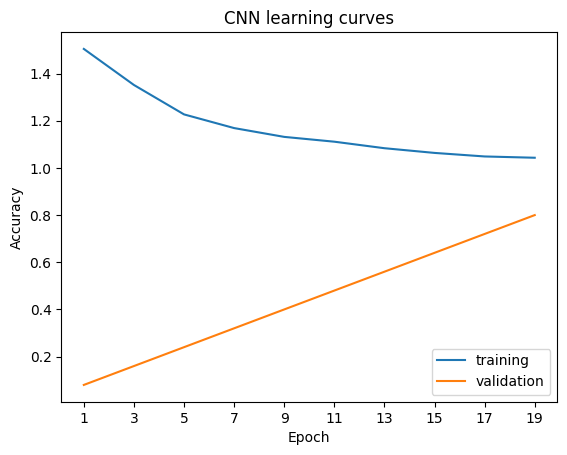

In [68]:
lines = df.plot.line(y=['eval_loss', 'epoch'])
plt.title('Validation loss ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks( df.index.values )
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

## 7. Applying Chat template:
Suppose you want to switch to a different model and accordingly the prompt template needs to change. So, how would you incorporate this change without having to manually apply the template everytime you change the model?

**Answer: **To automate the process of updating the prompt template when switching to a different model, we can implement huggingface chat_template that dynamically adjusts the template based on the selected model. To use it we can call the tokenizer.apply_chat_template as they are part of the tokenizer.

In [69]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/blenderbot-400M-distill")

chat = [
   {"role": "user", "content": "Hello, how are you?"},
   {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
   {"role": "user", "content": "I'd like to show off how chat templating works!"},
]

tokenizer.apply_chat_template(chat, tokenize=False)

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/62.9k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/310k [00:00<?, ?B/s]


No chat template is defined for this tokenizer - using the default template for the BlenderbotTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



" Hello, how are you?  I'm doing great. How can I help you today?   I'd like to show off how chat templating works!</s>"

In [70]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

chat = [
  {"role": "user", "content": "Hello, how are you?"},
  {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
  {"role": "user", "content": "I'd like to show off how chat templating works!"},
]

tokenizer.apply_chat_template(chat, tokenize=False)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

"<s>[INST] Hello, how are you? [/INST]I'm doing great. How can I help you today?</s> [INST] I'd like to show off how chat templating works! [/INST]"